In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from pathlib import Path
from plotnine import * 
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_absolute_error

# It provides an automated way to search for the best machine learning model and its hyperparameters given a dataset. 
from flaml import AutoML
from flaml.automl.model import LGBMEstimator

# Display the plots directly within the notebook itself insteadd of opening a separate window
%matplotlib inline

# Sets the figure format to 'retina' for high-resolution displays
%config InlineBackend.figure_format='retina'

In [2]:
pd.set_option('display.max_rows', 50)

target_name = 'yield'

# nested CV to ensure true out of fold metrics
n_outer_folds = 9
n_folds = 10
n_repeats = 10

first_time_budget = 1 #1200  # Exploration Budget for first fit
min_time_budget = 1 ##10     # subseqent fit times are reduced

include_original = True

random_state = 2112 # overture...

np.random.seed(random_state)

In [3]:
test_data = pd.read_csv('test.csv')
test_data['data_type'] = 0
train_data = pd.read_csv('train_combine.csv')
train_data['data_type'] = 0

train_data.head(10)

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield,data_type
0,0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146,0
1,1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201,0
2,2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760,0
3,3,12.5,0.25,0.25,0.63,0.50,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.565976,0.478137,39.467561,6880.77590,0
4,4,25.0,0.50,0.25,0.63,0.63,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.579677,0.494165,40.484512,7479.93417,0
5,5,25.0,0.50,0.25,0.63,0.75,94.6,57.2,79.0,68.2,33.0,55.9,34.0,0.56,0.565239,0.484350,40.555019,7267.28344,0
6,6,12.5,0.25,0.38,0.50,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.498730,0.442193,35.517539,5739.68029,0
7,7,12.5,0.25,0.25,0.75,0.75,86.0,52.0,71.9,62.0,30.0,50.8,1.0,0.10,0.619888,0.529502,42.191013,7920.06175,0
8,8,25.0,0.50,0.38,0.38,0.75,94.6,57.2,79.0,68.2,33.0,55.9,16.0,0.26,0.532557,0.465367,36.166044,6465.37205,0
9,9,25.0,0.50,0.25,0.63,0.63,94.6,57.2,79.0,68.2,33.0,55.9,34.0,0.56,0.340063,0.381768,28.763565,3519.43131,0


In [4]:
# Reviewing Correlation between attributes
correlations = round(train_data.corr(),4)
correlations # 1 represent full positive correlation, -1 represent negative correllation

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield,data_type
id,1.0000,-0.0080,0.0161,-0.0026,-0.0041,-0.0122,0.0096,0.0091,0.0093,0.0098,0.0094,0.0094,-0.0002,-0.0004,0.0049,0.0032,-0.0000,0.0002,NaN
clonesize,-0.0080,1.0000,0.2664,0.0766,0.0620,-0.0142,0.0170,0.0167,0.0169,0.0172,0.0169,0.0168,0.1559,0.1548,-0.4147,-0.3827,-0.4021,-0.3893,NaN
honeybee,0.0161,0.2664,1.0000,-0.0446,0.0093,-0.0351,0.0079,0.0077,0.0080,0.0080,0.0079,0.0075,0.0298,0.0200,-0.1012,-0.1329,-0.1366,-0.1034,NaN
bumbles,-0.0026,0.0766,-0.0446,1.0000,-0.1542,0.1671,-0.0033,-0.0020,-0.0025,-0.0029,-0.0026,-0.0023,-0.0565,-0.0526,0.1678,0.1752,0.1887,0.1691,NaN
andrena,-0.0041,0.0620,0.0093,-0.1542,1.0000,0.3154,-0.0138,-0.0135,-0.0137,-0.0137,-0.0138,-0.0138,-0.0230,-0.0231,0.0753,0.0664,0.0650,0.0775,NaN
osmia,-0.0122,-0.0142,-0.0351,0.1671,0.3154,1.0000,-0.0333,-0.0315,-0.0328,-0.0335,-0.0330,-0.0326,-0.0696,-0.0673,0.2169,0.2011,0.2100,0.2087,NaN
MaxOfUpperTRange,0.0096,0.0170,0.0079,-0.0033,-0.0138,-0.0333,1.0000,0.9982,0.9997,0.9995,0.9998,0.9997,0.0106,0.0095,0.0004,0.1416,0.0559,-0.0306,NaN
MinOfUpperTRange,0.0091,0.0167,0.0077,-0.0020,-0.0135,-0.0315,0.9982,1.0000,0.9989,0.9977,0.9988,0.9990,0.0111,0.0101,0.0018,0.1430,0.0573,-0.0295,NaN
AverageOfUpperTRange,0.0093,0.0169,0.0080,-0.0025,-0.0137,-0.0328,0.9997,0.9989,1.0000,0.9994,1.0000,1.0000,0.0105,0.0095,0.0016,0.1432,0.0573,-0.0298,NaN
MaxOfLowerTRange,0.0098,0.0172,0.0080,-0.0029,-0.0137,-0.0335,0.9995,0.9977,0.9994,1.0000,0.9994,0.9993,0.0105,0.0094,0.0007,0.1420,0.0563,-0.0303,NaN


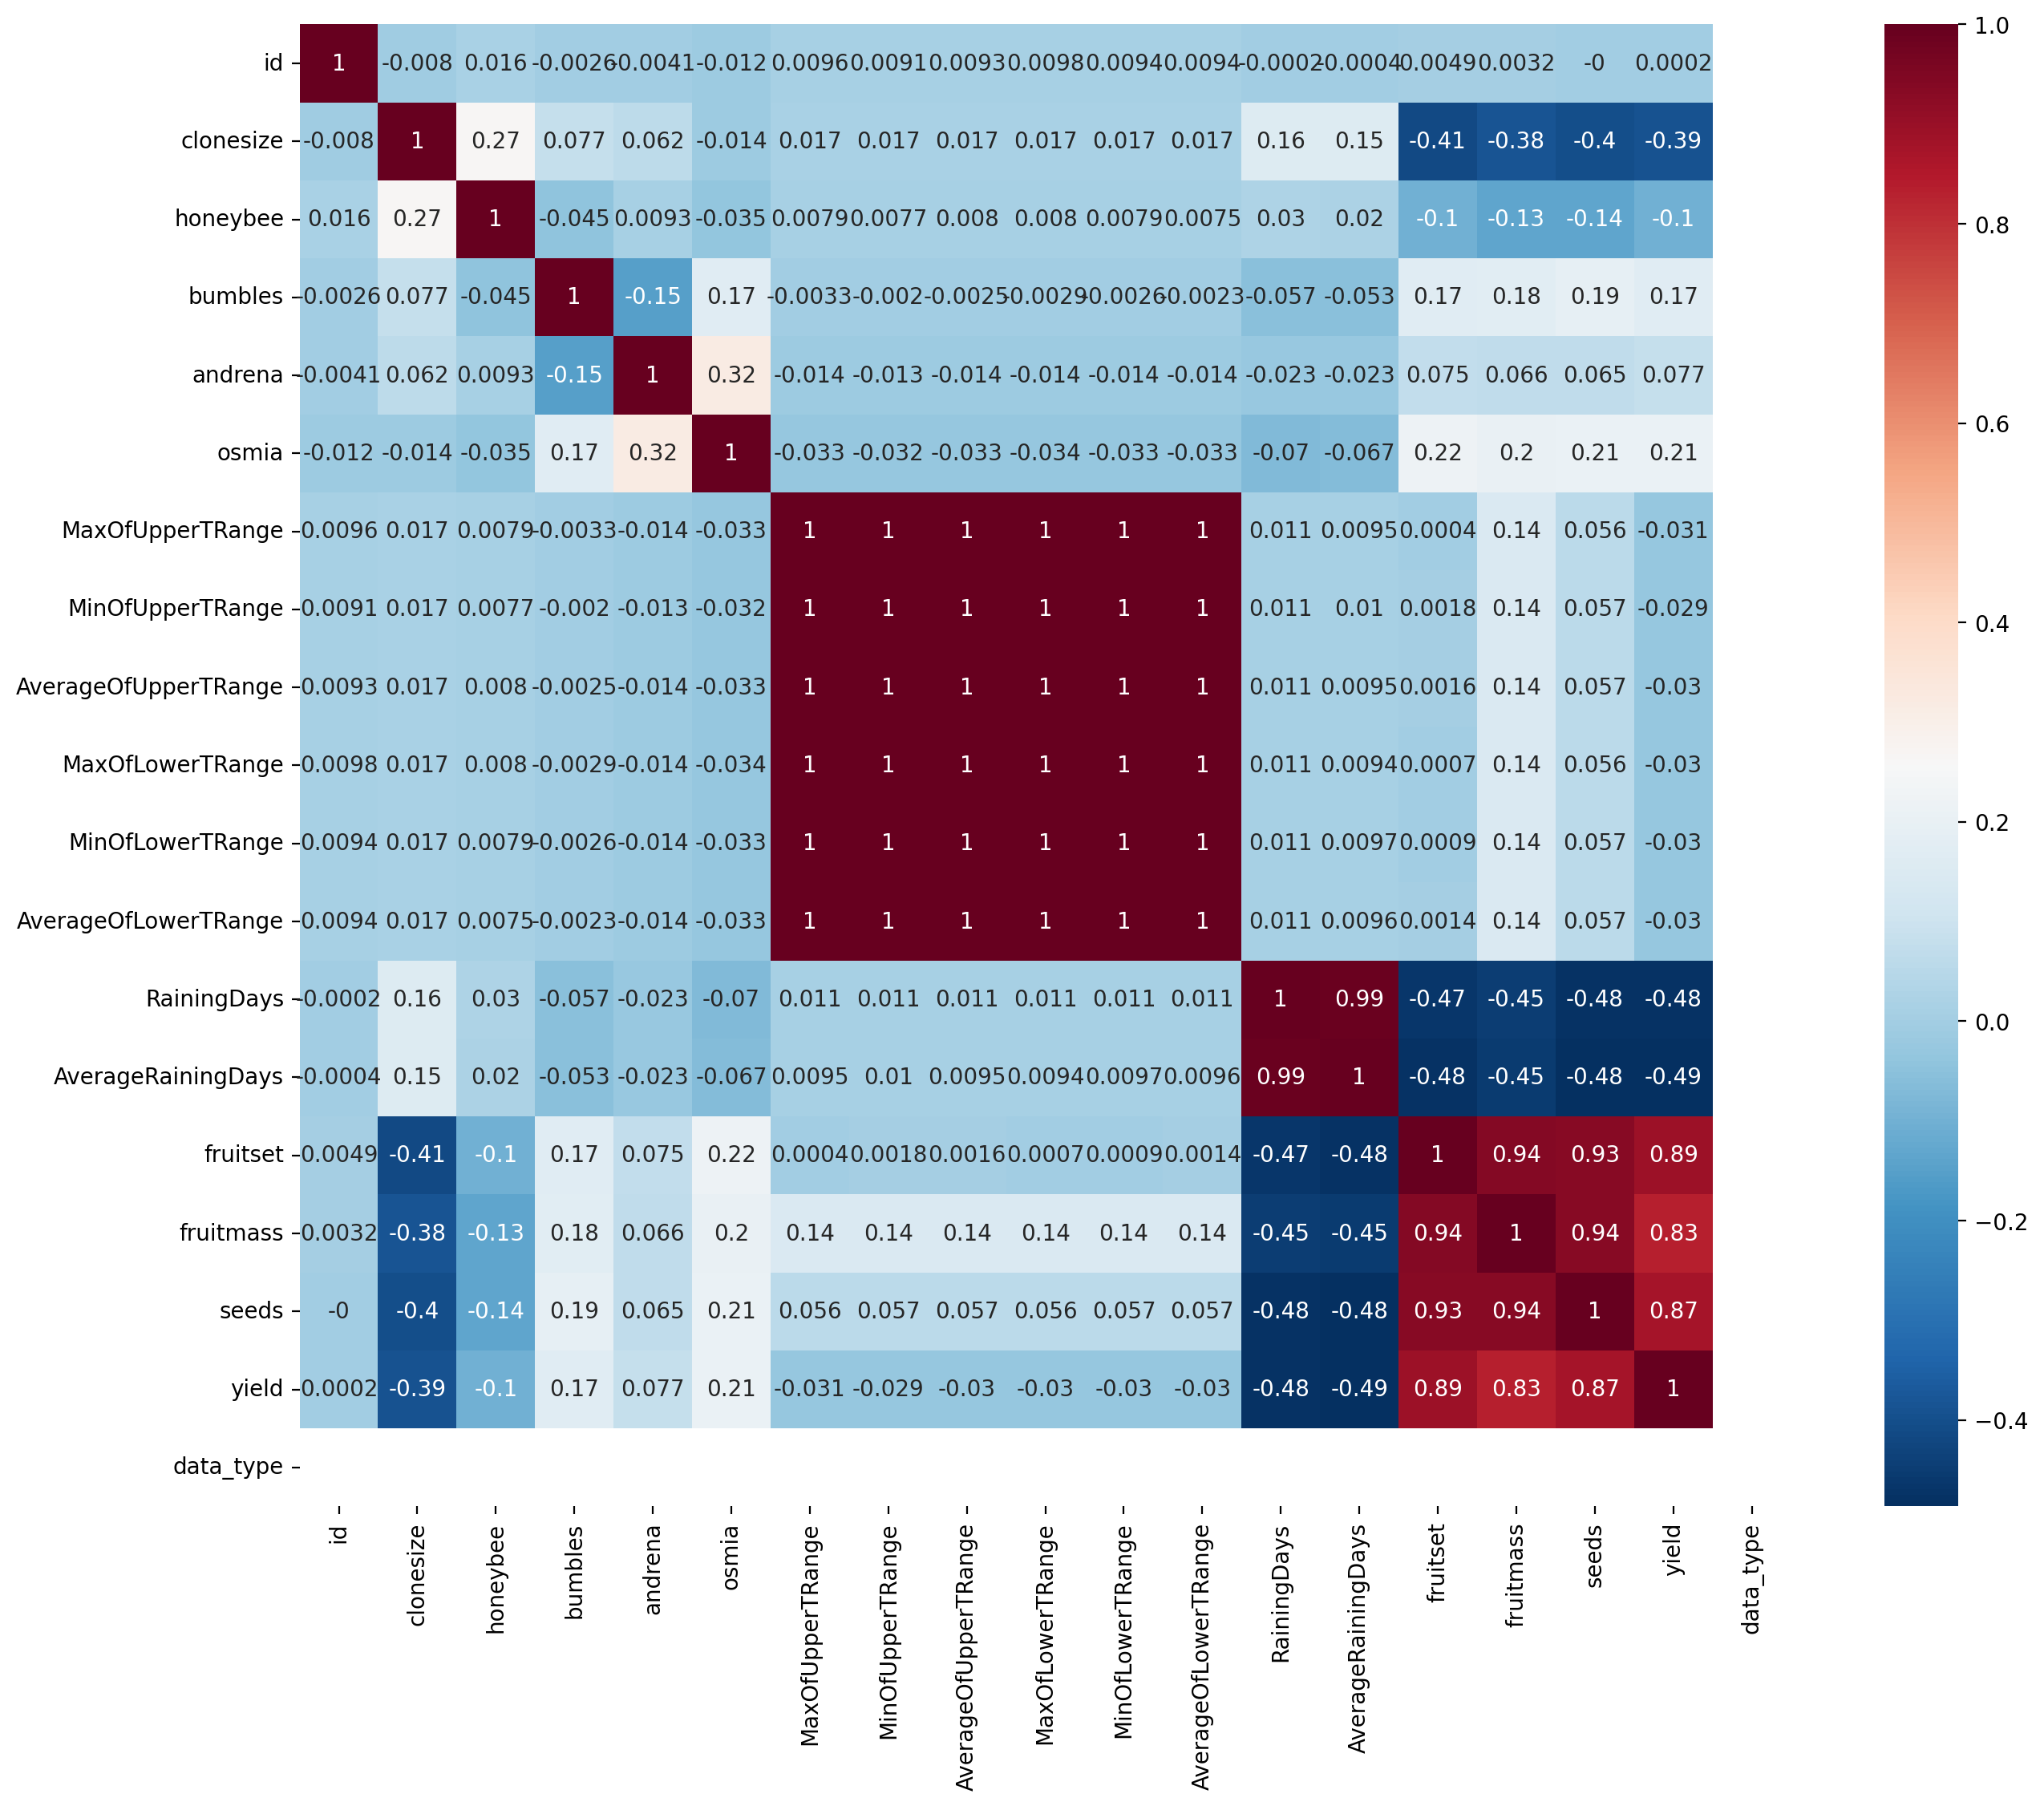

In [5]:
plt.figure(figsize=(15,12))
sns.heatmap(correlations, annot=True,cmap ='RdBu_r')
plt.show()

In [6]:
# Loop over bottom diagonal of correlation matrix
threshold = 0.9
high_corr = []
for i in range(len(correlations.columns)):
    for j in range(i):
        if abs(correlations.iloc[i, j]) > threshold:
            colname = correlations.columns[i]
            high_corr.append(colname)
            
set(high_corr)

# remove highly correlated features
# df.drop(high_corr, axis=1, inplace=True)

{'AverageOfLowerTRange',
 'AverageOfUpperTRange',
 'AverageRainingDays',
 'MaxOfLowerTRange',
 'MinOfLowerTRange',
 'MinOfUpperTRange',
 'fruitmass',
 'seeds'}

In [7]:
# Merge features and targets together for checking correlation
X_y = train_data.copy()

correlation_X_y = X_y.corr()
correlation_target = correlation_X_y [['yield']].drop(labels=['yield'])
correlation_target

,yield
id,0.000183
clonesize,-0.389311
honeybee,-0.103364
bumbles,0.169122
andrena,0.077499
osmia,0.208686
MaxOfUpperTRange,-0.030623
MinOfUpperTRange,-0.029537
AverageOfUpperTRange,-0.029808
MaxOfLowerTRange,-0.030340


In [8]:
features = ['MinOfLowerTRange', 'RainingDays', 'fruitmass', 'fruitset', 'seeds', 'bumbles', 'clonesize']
    
target = np.unique(train_data["yield"])

def mattop_post_process(preds):
     return np.array([min(target, key = lambda x: abs(x - pred)) for pred in preds])

In [9]:
train_data.filter(features).describe().T

,count,mean,std,min,25%,50%,75%,max
MinOfLowerTRange,16066.0,28.661988,3.195960,24.300000,27.000000,30.000000,30.000000,33.000000
RainingDays,16066.0,18.643862,11.680433,1.000000,16.000000,16.000000,24.000000,34.000000
fruitmass,16066.0,0.446525,0.037200,0.311921,0.418867,0.446570,0.474777,0.535660
fruitset,16066.0,0.502711,0.074639,0.192732,0.457833,0.506686,0.560709,0.652144
seeds,16066.0,36.162894,4.048407,22.079199,33.232449,36.047770,39.158238,46.585105
bumbles,16066.0,0.286556,0.060249,0.000000,0.250000,0.250000,0.380000,0.585000
clonesize,16066.0,19.659374,6.618134,10.000000,12.500000,25.000000,25.000000,40.000000


In [10]:
from flaml.automl.model import LGBMEstimator

# customisation to set LGB objective to L1 loss
class MyLGBM(LGBMEstimator):
    """customise objective for l1 loss"""

    def __init__(self, **config):
        super().__init__(objective="regression_l1", **config)

In [11]:
def fold_mae(y, preds, data_type):
    return mean_absolute_error(y[data_type==0], preds[data_type==0])

# Find the importance features

def get_features_important(automl, estimator_name, X, y):
    
    fi = pd.DataFrame({
        'estimator_name': [],
        'Feature': [],
        'Importance': []})
    
    try:
        est = automl.model.named_estimators_['lgbm']
        imp = permutation_importance(est, X, y)
        fi = pd.DataFrame({
            'Importance': imp.importances_mean,
            'Feature': X.columns})
    except:
        try:
            est = automl.model
            imp = permutation_importance(est, X, y)
            fi = pd.DataFrame({
                'Importance': imp.importances_mean,
                'Feature': X.columns})
        except:
            pass
    
    # Ensures it contains feature importance data
    
    if len(fi) > 0:
        fi = fi.assign(estimator_name=estimator_name)
    
    return fi


class AutoMLFitter:
    # A wrap of the automl call to allow us to
    # decrease the time budget for each call
    # And keep track of the best parameters found
    
    def __init__(self, name, time_budget, estimator_list=[], best_config=None, n_folds=10):
        self.name = name
        self.time_budget = time_budget
        self.estimator_list = estimator_list
        self.best_config = best_config
        self.n_folds = n_folds

    def fit_automl(self, random_state, X, y):

        automl_settings = {
            "time_budget": self.time_budget,
            "metric": 'mae',
            "task": 'regression',
            "log_file_name": "",
            "ensemble": False,
            "eval_method": 'cv',
            "n_splits": self.n_folds,
            "seed": random_state,
            "verbose": 0,
            "estimator_list": self.estimator_list
        }

        # time budget is decreased on each fit.
        self.time_budget //= 1.5
        if self.time_budget < min_time_budget:
            self.time_budget = min_time_budget

        automl = AutoML()
        automl.add_learner(learner_name='my_lgbm', learner_class=MyLGBM)
        automl_settings["estimator_list"] = ['my_lgbm' ]  # change the estimator list
        
        automl.fit(X, y, starting_points=self.best_config, **automl_settings)
        self.best_config = automl.best_config_per_estimator

        return automl

In [12]:
def fit_nested_automl(model_fitters, random_state, train_data, test_data, features):
                               
    k_fold = KFold(n_splits=n_outer_folds, random_state=random_state, shuffle=True)
    
    fast_fis = []
    oof_metrics = []
    test_preds = np.zeros(len(test_data))
    oof_preds = np.zeros(len(train_data))
    
    print('OOF Metric: ', end='')
    for train_index, test_index in k_fold.split(train_data, train_data[target_name]):
        tr, vl = train_data.loc[train_index], train_data.loc[test_index]
        
        # for each model:
        oof_pred = np.zeros(len(vl))
        test_pred = np.zeros(len(test_data))
        best_loss = 0
        
        for model_fitter in model_fitters:
            
            automl = model_fitter.fit_automl(
                random_state, 
                tr.filter(features), 
                tr[target_name].values)
        
            oof_pred  += automl.predict(vl.filter(features)) / len(model_fitters)
            test_pred += automl.predict(test_data.filter(features)) / len(model_fitters)
            best_loss += automl.best_loss / (len(model_fitters))
        
            fast_fi =  get_features_important(automl, model_fitter.name, vl.filter(features), vl[target_name])
            fast_fis.append(fast_fi)
        
        oof_metric = fold_mae(
            vl[target_name].values, 
            oof_pred, 
            vl['data_type'].values)
        
        print(f'{oof_metric:4.1f}', end=' ')
        
        oof_preds[test_index] += oof_pred
        test_preds += test_pred / n_outer_folds
        fast_fis.append(fast_fi)
        oof_metrics.append(oof_metric)

    return oof_preds, test_preds, fast_fis, oof_metrics


def fit(model_fitters, train_data, test_data, features):
    test_preds = np.zeros(len(test_data))
    oof_preds = np.zeros(len(train_data))
    oof_metrics = []
    oof_fold_metrics = []
    fast_fis = []
    for i in range(n_repeats): 
        # fit
        oof_pred, test_pred, fast_fi, oof_fold_metric = fit_nested_automl(
            model_fitters,
            random_state + i,
            train_data.sample(frac=1),
            test_data,
            features)

        oof_metric = fold_mae(
            train_data[target_name].values, 
            oof_pred, 
            train_data['data_type'].values)
        
        oof_metric_pp = fold_mae(
            train_data[target_name].values, 
            mattop_post_process(oof_pred), 
            train_data['data_type'].values)

        test_preds += (test_pred) / n_repeats
        oof_preds += (oof_pred) / n_repeats

        oof_fold_metrics.extend(oof_fold_metric)
        fast_fis.extend(fast_fi)

        print(f'| Repeat {i}: {oof_metric:4.1f} mattop postprocessing {oof_metric_pp:4.1f}')
        
    return oof_preds, test_preds, oof_fold_metrics, fast_fis

In [13]:
tr = train_data.sample(frac=1, random_state=random_state)

model_fitter = AutoMLFitter(
    name='model',
    time_budget= first_time_budget, 
    n_folds=5) # nested CV: 8/9 * 9/10 = 80%, equivalent to 5 folds

# here's one I made earlier:
# running the fitter with a longer budget will discover these 
# hyperparameters:
model_fitter.best_config = {
    'my_lgbm': {'n_estimators': 265, 'num_leaves': 93, 'min_child_samples': 20, 
                'learning_rate': 0.05533790147941807, 'log_max_bin': 10, 
                'colsample_bytree': 0.8809128870084636, 'reg_alpha': 0.0009765625, 
                'reg_lambda': 0.015589408048174165}}

model_fitter.fit_automl(
    random_state, 
    tr.filter(features), 
    tr[target_name].values)

model_fitter.time_budget = min_time_budget
model_fitter.n_folds = n_folds

print(model_fitter.best_config)

models = [model_fitter]
# model fit & output
oof_preds, test_preds, oof_fold_metrics, fast_fis = fit(models, train_data, test_data, features)

{'my_lgbm': {'n_estimators': 265, 'num_leaves': 93, 'min_child_samples': 20, 'learning_rate': 0.05533790147941807, 'log_max_bin': 10, 'colsample_bytree': 0.8809128870084636, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.01558940804817417}}
OOF Metric: 344.6 320.8 319.2 320.1 307.1 328.0 334.8 343.8 340.1 | Repeat 0: 328.7 mattop postprocessing 328.7
OOF Metric: 339.5 326.7 326.7 322.7 345.4 329.1 331.6 333.3 306.4 | Repeat 1: 329.0 mattop postprocessing 328.9
OOF Metric: 333.9 336.0 329.3 325.3 337.3 322.6 330.8 320.2 322.2 | Repeat 2: 328.6 mattop postprocessing 328.5
OOF Metric: 314.9 312.6 331.4 341.2 324.4 337.6 324.2 340.6 334.0 | Repeat 3: 329.0 mattop postprocessing 328.9
OOF Metric: 322.1 333.1 323.8 325.3 319.7 335.6 328.5 344.5 323.9 | Repeat 4: 328.5 mattop postprocessing 328.4
OOF Metric: 339.5 325.4 344.5 315.9 328.8 336.5 331.5 316.5 318.8 | Repeat 5: 328.6 mattop postprocessing 328.6
OOF Metric: 305.2 334.0 331.3 323.6 333.0 342.3 332.4 329.4 324.8 | Repeat 6: 328.4 mattop 

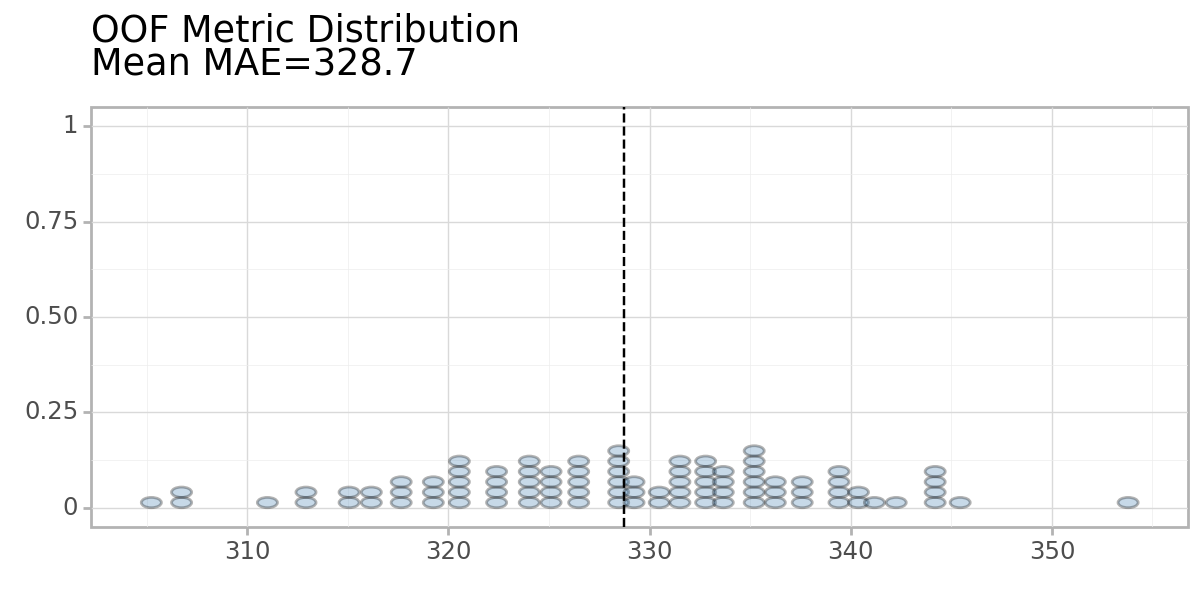

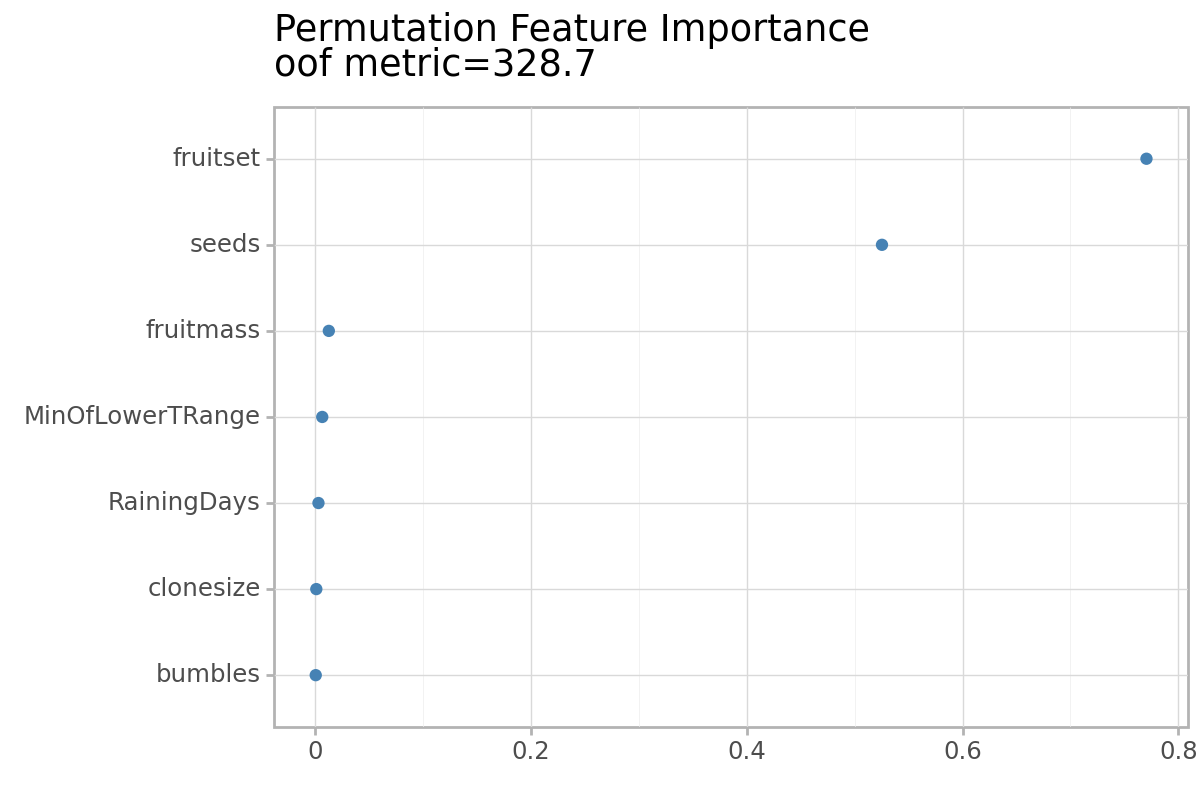


            Feature  mean_imp   std_imp
2           bumbles  0.000418  0.000373
3         clonesize  0.000950  0.000628
1       RainingDays  0.002953  0.001019
0  MinOfLowerTRange  0.006461  0.001560
4         fruitmass  0.012554  0.002978
6             seeds  0.525350  0.031019
5          fruitset  0.770532  0.045619


In [14]:
df_metrics = pd.DataFrame({'oof': oof_fold_metrics})
print(ggplot(df_metrics, aes(x='oof'))
    + theme_light()
    + theme(figure_size=(6, 3))
    + geom_dotplot(alpha=0.3, binwidth = 1, fill='SteelBlue')
    + geom_vline(xintercept=np.mean(oof_fold_metrics), linetype='dashed')
    + labs(
        y = '', x='', 
        title = f'OOF Metric Distribution\nMean MAE={np.mean(oof_fold_metrics):4.1f}'))

df_importance = pd.concat(fast_fis).sort_values(['Importance'])
if len(df_importance) > 0:
    df_importance_mean = (
        df_importance
        .groupby(['Feature'], as_index=False)
        .agg(mean_imp=('Importance', 'mean'), std_imp=('Importance', 'std'))
        .sort_values(['mean_imp']))

    feature_list = df_importance_mean['Feature'].tolist()
    feature_cat  = pd.Categorical(df_importance_mean['Feature'], categories=feature_list) #[::-1])
    
    df_importance_mean = (df_importance_mean
        .assign(
            feature_cat = feature_cat,
            mean_imp_min = lambda x: x['mean_imp'] - 2 * x['std_imp'],
            mean_imp_max = lambda x: x['mean_imp'] + 2 * x['std_imp']))
    
    df_importance = df_importance.merge(df_importance_mean.filter(['Feature', 'feature_cat']))

    print(ggplot(df_importance, aes(y='feature_cat', x='Importance')) 
        + theme_light()
        + theme(figure_size=(6, 4))
        #+ geom_jitter(alpha=0.2, size=0.5, height=0.1)
        + geom_point(mapping=aes(x='mean_imp'), colour='SteelBlue', data=df_importance_mean) 
        #+ geom_errorbarh(
        #    mapping=aes(x='mean_imp', xmin='mean_imp_min', xmax='mean_imp_max'), 
        #    alpha=0.5,  data=df_importance_mean)  
        + labs(
            y = '', x='', 
            title = (f'Permutation Feature Importance\n'
                f'oof metric={np.mean(oof_fold_metrics):4.1f}'))
        #+ facet_wrap('estimator_name', ncol=2)
         )
    
if len(df_importance) > 0:
    print(df_importance_mean.filter(['Feature', 'mean_imp', 'std_imp']).head(20))

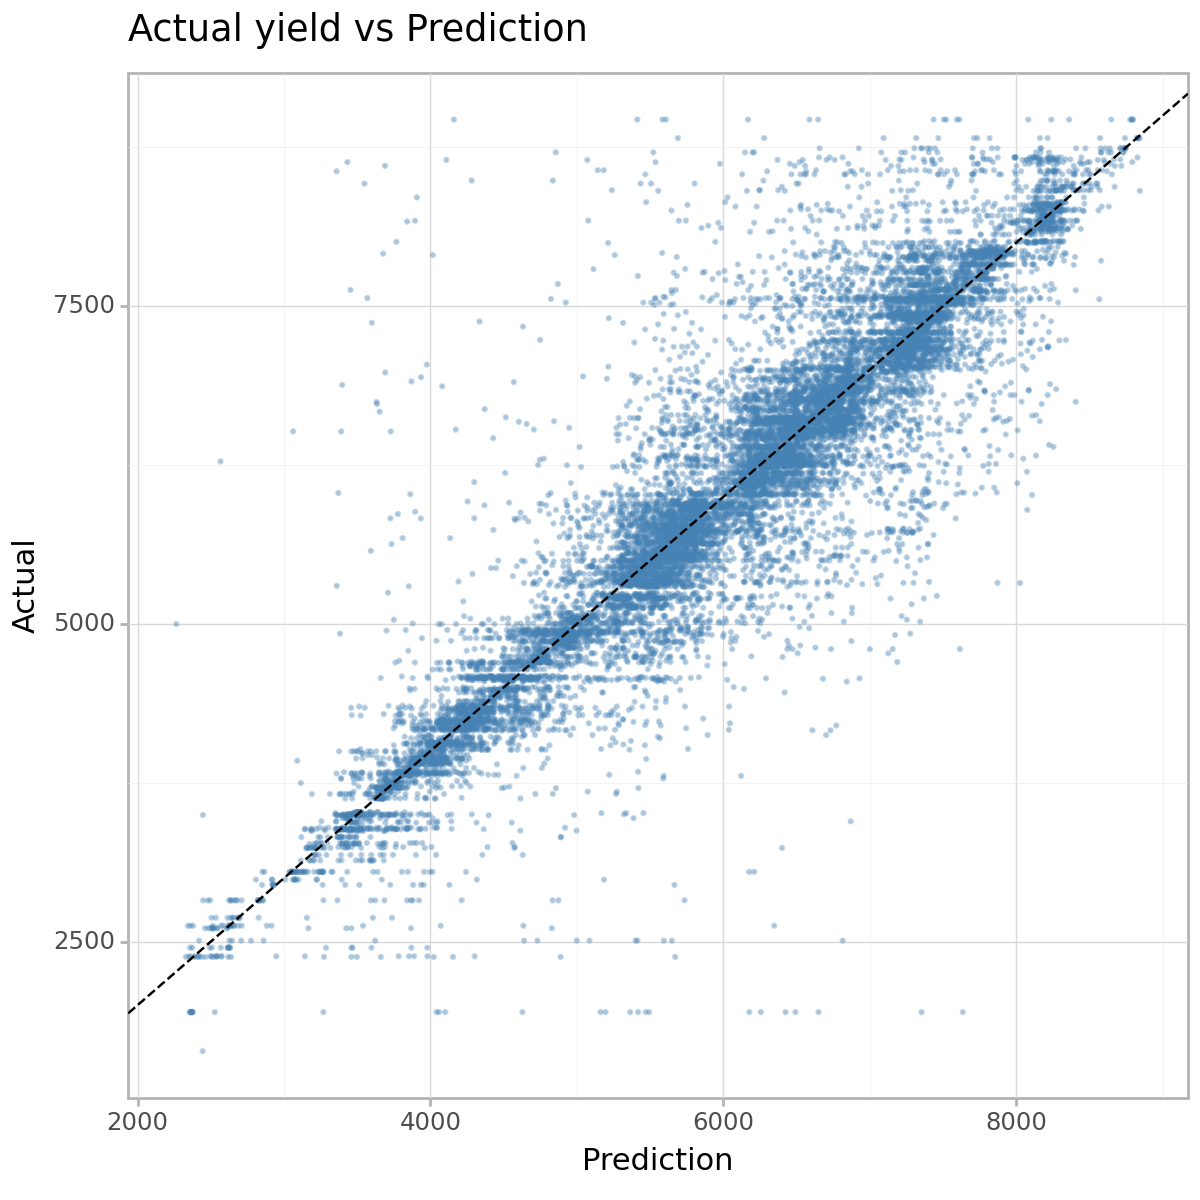

In [15]:
pred_data = train_data.assign(pred=oof_preds)
print(ggplot(pred_data, aes(x='pred', y=target_name))
    + theme_light()
    + theme(figure_size=(6, 6))
    + geom_point(alpha=0.3, size=0.3, colour='SteelBlue')
    + geom_abline(intercept=0, slope=1, linetype='dashed')
    + labs(y='Actual', x='Prediction', title=f'Actual {target_name} vs Prediction'))

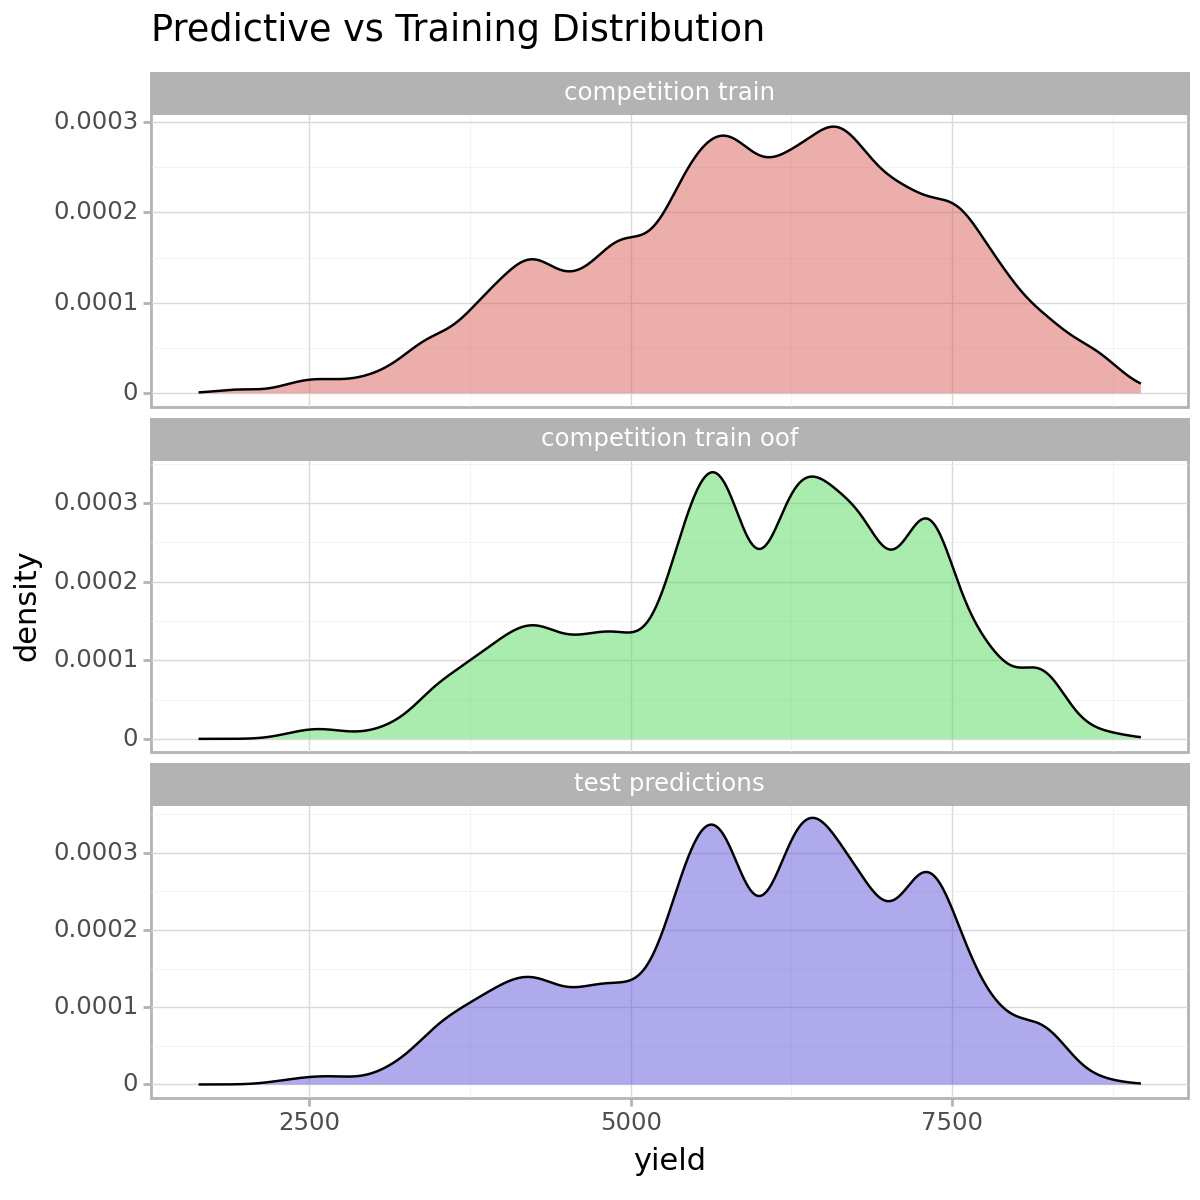

In [16]:
df_dist = pd.concat([
    (train_data
        .assign(
            source=lambda x: 
                np.where(x['data_type'] == 0, 'competition train', 'original train'))
        .filter([target_name, 'source'])),
    (test_data
        .filter(['Strength'])
        .assign(**{target_name: test_preds})
        .assign(source='test predictions')),
    (pred_data
        .filter(['pred'])
        .rename(columns={'pred': target_name})
        .assign(source='competition train oof'))])


print(ggplot(df_dist, aes(x=target_name, fill='source'))
    + theme_light()
    + theme(
        figure_size=(6, 6),
        legend_position='none')
    + geom_density(alpha=0.5) 
    + facet_wrap('source', ncol=1, scales='free_y')
    + labs(title='Predictive vs Training Distribution'))

## Part 2

In [17]:
SEED = 1984
target = "yield"

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

class PLSRegressionWrapper(PLSRegression):
    def transform(self, X):
        return super().transform(X)
    def fit_transform(self, X, Y):
        return self.fit(X,Y).transform(X)

import lightgbm as lgb

In [18]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train_combine.csv')

train.loc[train["RainingDays"]==26, "RainingDays"] = 24
test.loc[test["RainingDays"]==33, "RainingDays"] = 34

for df in [train, test]:
    df.loc[df["MaxOfUpperTRange"].isin([71.9, 79, 89]), "MaxOfUpperTRange"] = 86

for df in [train, test]:
    display(df["RainingDays"].value_counts())
    display(df["MaxOfUpperTRange"].value_counts())

16.00    4555
24.00    4026
1.00     3713
34.00    3708
3.77       64
Name: RainingDays, dtype: int64

86.0    4417
77.4    3976
94.6    3928
69.7    3745
Name: MaxOfUpperTRange, dtype: int64

16.00    2831
24.00    2534
1.00     2438
34.00    2352
3.77       39
Name: RainingDays, dtype: int64

86.0    2730
77.4    2594
94.6    2532
69.7    2338
Name: MaxOfUpperTRange, dtype: int64

In [19]:
class MyFeaturesEngineering(BaseEstimator, TransformerMixin):
    
    def __init__(self, verbose = False, 
                 feats_for_pca = ["seeds", "fruitmass", "fruitset"], 
                 feats_for_pls = ["seeds", "fruitmass", "fruitset"]):
        
        self.verbose = verbose
        
        self.pca_components = len(feats_for_pca)
        self.feats_for_pca = feats_for_pca
        
        self.pls_components = len(feats_for_pls)
        self.feats_for_pls = feats_for_pls
        

    def fit(self, x, y=None):
        
        self.pipe_pca = make_pipeline(StandardScaler(), PCA(n_components = self.pca_components))
        self.pipe_pca.fit(x[self.feats_for_pca])
        
        self.pipe_pls = make_pipeline(StandardScaler(), PLSRegressionWrapper(n_components = self.pls_components))
        self.pipe_pls.fit(x[self.feats_for_pls], x[target])
        
        return self
    
    def transform(self, x, y=None):
        
        df = x.copy()
        
        pca_cols = [f"pca_{i}" for i in range(self.pca_components)]
        df[pca_cols] = self.pipe_pca.transform(df[self.feats_for_pca])
        
        pls_cols = [f"pls_{i}" for i in range(self.pls_components)]
        df[pls_cols] = self.pipe_pls.transform(df[self.feats_for_pls])
        
        return df

In [20]:
def fit_lgbm(params={}, features = None, use_original = False,
            n_splits = 5, seed = SEED, verbose = False,
             feats_for_pca = ["seeds", "fruitmass", "fruitset"], 
                 feats_for_pls = ["seeds", "fruitmass", "fruitset"]
            ):
    
    if features is None:
        features = test.columns
    best_iteration, val_score, trn_score = [], [], []
    eval_result={}
    callbacks = [lgb.early_stopping(100), lgb.record_evaluation(eval_result)]
    if verbose:
        callbacks.append(lgb.log_evaluation(200))
        
    oof = pd.Series(0, index=train.index)
    y_pred = pd.Series(0, index=test.index)
   
    # CV loop...
    folds = KFold(n_splits = n_splits, shuffle = True, random_state = seed)
    for fold, (trn_idx, val_idx) in enumerate(folds.split(train, train[target])):
        
        fe = MyFeaturesEngineering(feats_for_pca = feats_for_pca, feats_for_pls = feats_for_pls)
        if use_original: # Concat train and origin datasets for fitting
            X_trn = fe.fit_transform(pd.concat([train.loc[trn_idx]], axis=0))[features]
            y_trn = pd.concat([train.loc[trn_idx]], axis=0)[target]
        else:            # and don't
            X_trn = fe.fit_transform(train.loc[trn_idx])[features]
            y_trn = train.loc[trn_idx, target]

        # Don't use original dataset to fit
        X_val, y_val = fe.transform(train.loc[val_idx])[features], train.loc[val_idx, target]
        
        X_pred = fe.transform(test)[features]
        
        dtrn = lgb.Dataset(X_trn, label = y_trn) 
        dval = lgb.Dataset(X_val, label = y_val)

        # TRAIN MODEL        
        model = lgb.train(params, dtrn, num_boost_round = 2000, valid_sets = dval, callbacks = callbacks)#, categorical_feature = "auto")
        best_iteration.append(model.best_iteration)
        
        # Results, score
        oof.loc[val_idx] = model.predict(X_val, num_iteration = best_iteration[fold])
        y_pred += model.predict(X_pred, num_iteration = best_iteration[fold]) / n_splits
        val_score.append(mean_absolute_error(y_val, oof.loc[val_idx]))
        trn_score.append(mean_absolute_error(y_trn, model.predict(X_trn)))
        if verbose:
            print(f'Fold {fold + 1} - Valid : {val_score[fold]:.5f} - Train : {trn_score[fold]:.5f} - Best it. : {best_iteration[fold]:4}')
        
    # End CV Loop
    print(f"OOF MAE : {mean_absolute_error(train[target], oof):.5f} - Mean MAE {np.mean(val_score):.5f} - Overfeat {np.mean(trn_score) - np.mean(val_score):.5f} - Std {np.std(val_score):.5f}")
    
    return {"oof":oof, "oof_score":mean_absolute_error(train[target], oof), "overfeat":np.mean(trn_score) - np.mean(val_score),
           "best_iteration":best_iteration, "y_pred":y_pred}

In [21]:
params = {
    'objective':'regression_l1',
#    'num_leaves': 31, # Default : 31
#    'min_child_samples': 20, # Default : 20
    'learning_rate': 0.04, 
    'max_bin': 1000, # Default : 255
    'colsample_bytree': .8, # Default : 1
    'subsample': .7, # Default : 1
    'bagging_freq': 1,
    'random_state': SEED,
    'verbose':-1,
}

res1 = fit_lgbm(params, n_splits = 10, seed = SEED, verbose = True, use_original = True, 
               feats_for_pca = ['fruitset', 'seeds', 'fruitmass'], 
              features=["pca_0", "pca_1", 'RainingDays', 'fruitmass', 'MaxOfUpperTRange', 'fruitset', 'seeds'])


print(f"OOF MAE : {res1['oof_score']:.5f}")

Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 323.456
[400]	valid_0's l1: 321.533
[600]	valid_0's l1: 320.67
[800]	valid_0's l1: 319.991
Early stopping, best iteration is:
[763]	valid_0's l1: 319.865
Fold 1 - Valid : 319.86516 - Train : 284.86507 - Best it. :  763
[200]	valid_0's l1: 318.268
[400]	valid_0's l1: 317.027
Early stopping, best iteration is:
[386]	valid_0's l1: 316.912
Fold 2 - Valid : 316.91169 - Train : 300.77582 - Best it. :  386
[200]	valid_0's l1: 322.208
[400]	valid_0's l1: 321.469
Early stopping, best iteration is:
[386]	valid_0's l1: 316.912
Fold 3 - Valid : 321.43106 - Train : 299.60734 - Best it. :  386
[200]	valid_0's l1: 319.656
[400]	valid_0's l1: 318.126
Early stopping, best iteration is:
[386]	valid_0's l1: 316.912
Fold 4 - Valid : 318.23056 - Train : 300.22258 - Best it. :  386
[200]	valid_0's l1: 329.01
[400]	valid_0's l1: 327.492
Early stopping, best iteration is:
[386]	valid_0's l1: 316.912
Fold 5 - Valid : 327.65322 - 

In [22]:
res2 = fit_lgbm(params, n_splits = 10, seed = SEED, verbose = True, use_original = True, 
               feats_for_pca = ['fruitset', 'seeds', 'fruitmass'], feats_for_pls = ['fruitset', 'seeds'], 
              features=["pls_0", "pca_0", "pca_1", 'RainingDays', 'fruitmass', 'MaxOfUpperTRange', 'fruitset', 'seeds'])

Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 323.83
[400]	valid_0's l1: 321.877
[600]	valid_0's l1: 320.738
[800]	valid_0's l1: 320.345
Early stopping, best iteration is:
[896]	valid_0's l1: 319.956
Fold 1 - Valid : 319.95569 - Train : 280.20397 - Best it. :  896
[200]	valid_0's l1: 319.707
[400]	valid_0's l1: 317.662
Early stopping, best iteration is:
[434]	valid_0's l1: 317.295
Fold 2 - Valid : 317.29484 - Train : 298.16613 - Best it. :  434
[200]	valid_0's l1: 322.655
[400]	valid_0's l1: 322.314
Early stopping, best iteration is:
[434]	valid_0's l1: 317.295
Fold 3 - Valid : 322.14386 - Train : 297.00207 - Best it. :  434
[200]	valid_0's l1: 319.613
[400]	valid_0's l1: 318.01
Early stopping, best iteration is:
[434]	valid_0's l1: 317.295
Fold 4 - Valid : 317.75303 - Train : 297.58485 - Best it. :  434
[200]	valid_0's l1: 331.382
[400]	valid_0's l1: 329.588
Early stopping, best iteration is:
[434]	valid_0's l1: 317.295
Fold 5 - Valid : 329.52259 - 

In [24]:
from sklego.linear_model import LADRegression # Least Absolute Deviation Regression
# from sklearn.linear_model import HuberRegressorf

from sklearn.linear_model import Ridge

import matplotlib.pyplot as plt

In [26]:
oofs = pd.DataFrame(index=train.index)
oofs = pd.concat([oofs, 
                  pd.Series(oof_preds[:train.shape[0]], index=train.index), 
                  res1["oof"], 
                  res2["oof"]], axis=1)
oofs.columns=["Prediction1", "Prediction2", "Prediction3"]

preds = pd.DataFrame(index=test.index)
preds = pd.concat([preds, 
                  pd.Series(test_preds, index=test.index), 
                  res1["y_pred"], 
                  res2["y_pred"]], axis=1)
preds.columns=["Prediction1", "Prediction2", "Prediction3"]
display(oofs)
display(preds)

,Prediction1,Prediction2,Prediction3
0,4521.404542,4612.505665,4611.496051
1,4984.623503,4974.560136,4890.366478
2,6647.381933,6700.832566,6715.220690
3,6907.514527,6846.530554,6851.149218
4,7124.097096,7329.212708,7305.854232
...,...,...,...
16061,5688.242074,5643.263803,5585.349020
16062,3543.335148,3545.224723,3522.070387
16063,4345.624450,4285.470920,4315.383188
16064,4161.377194,4164.051154,4167.116232


,Prediction1,Prediction2,Prediction3
0,4312.776595,4311.764402,4314.002261
1,5868.830468,5880.830044,5910.318874
2,7276.648792,7228.027659,7239.348005
3,4496.930476,4625.653047,4640.513433
4,3842.271316,3838.067443,3833.082667
...,...,...,...
10189,5407.181130,5433.126773,5426.168981
10190,5604.997481,5618.513697,5630.414170
10191,6491.529161,6494.402680,6486.005887
10192,4421.473151,4421.620954,4406.392102


In [27]:
print(f"MAE with mean of 3 OOFS predictions : {mean_absolute_error(train[target], oofs.mean(axis=1))}")

MAE with mean of 3 OOFS predictions : 326.7428017316847


In [28]:
ridge_blend = Ridge(positive = True)
ridge_blend.fit(oofs, train[target])
print(f"MAE with Ridge Regression of 3 OOFS predictions : {mean_absolute_error(train[target], ridge_blend.predict(oofs))}\n\nCoefficients :")
display(pd.Series(ridge_blend.coef_.round(2), oofs.columns, name='weight'))

MAE with Ridge Regression of 3 OOFS predictions : 329.1227894240076

Coefficients :


Prediction1    0.76
Prediction2    0.19
Prediction3    0.02
Name: weight, dtype: float64

In [29]:
LADRegression_blend = LADRegression()
LADRegression_blend.fit(oofs, train[target])
print(f"MAE with LAD Regression of 3 OOFS predictions : {mean_absolute_error(train[target], LADRegression_blend.predict(oofs))}\n\nCoefficients :")
display(pd.Series(LADRegression_blend.coef_.round(2), oofs.columns, name='weight'))

MAE with LAD Regression of 3 OOFS predictions : 326.0831968511603

Coefficients :


Prediction1    0.70
Prediction2    0.21
Prediction3    0.10
Name: weight, dtype: float64

In [30]:
result_df = pd.Series([
    mean_absolute_error(train[target], oofs["Prediction1"]),
    mean_absolute_error(train[target], oofs["Prediction2"]),
    mean_absolute_error(train[target], oofs["Prediction3"]),
    mean_absolute_error(train[target], oofs.mean(axis=1)),
    mean_absolute_error(train[target], ridge_blend.predict(oofs)),
    mean_absolute_error(train[target], LADRegression_blend.predict(oofs)),
    ], index = ["Prediction1", "Prediction2", "Prediction3", "Blend_Mean", "Blend_Ridge", "Blend_LAD"], name="MAE")
result_df

Prediction1    326.586559
Prediction2    328.624666
Prediction3    329.108366
Blend_Mean     326.742802
Blend_Ridge    329.122789
Blend_LAD      326.083197
Name: MAE, dtype: float64

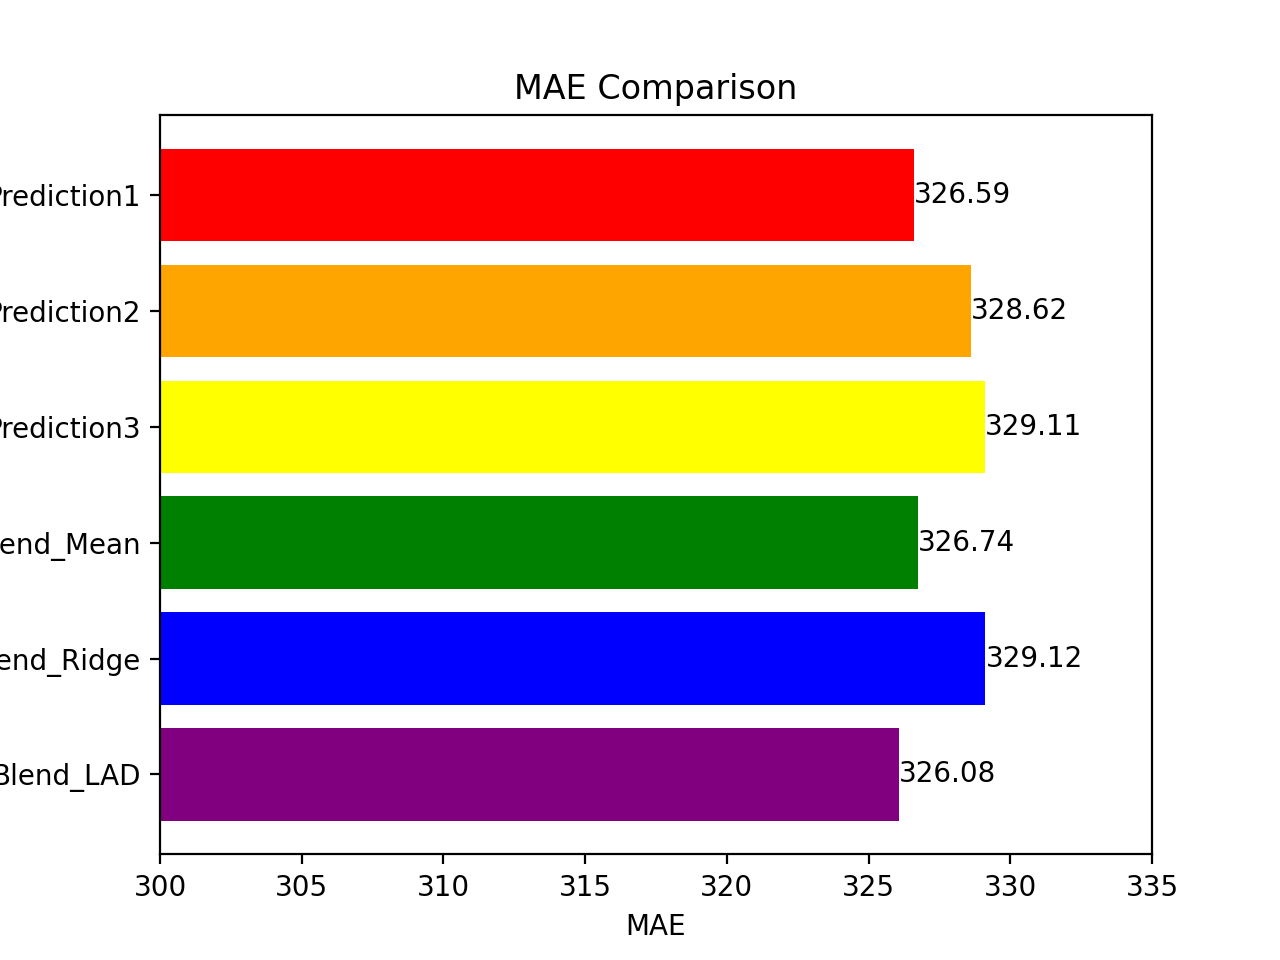

In [31]:
bars = plt.barh(result_df.index, result_df, color=["red", "orange", "yellow", "green", "blue", "purple"])
plt.gca().bar_label(bars, fmt='%.2f')
plt.gca().invert_yaxis()
plt.yticks(np.arange(len(result_df)), result_df.index)
plt.xlabel('MAE')
plt.title('MAE Comparison')

plt.xlim(300, 335);


In [32]:
column1 = test_data['id']
final_predicted = LADRegression_blend.predict(preds)
print(final_predicted)
column1 = test_data['id']
column2 = list(final_predicted)
dataset=pd.DataFrame({'id':column1,'yield':column2})
dataset.to_csv('submission.csv',index=False)

[4305.89345772 5871.50239858 7261.69780434 ... 6488.90197523 4413.44953298
 7194.57916175]
